### Importing Packages

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery, storage

# from utils import *
from ten_chart import *
import math
import talib

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from termcolor import colored as cl 

sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)


from datetime import datetime, timedelta, date
import datetime

# Using graph_objects
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

### Extracting DATA

In [2]:
# present day
dt='20221206'

query = f"""

    WITH content_t AS (
        SELECT 
            natid,
            title,
            pub_date,
            pub_time,
            pub_date_time

        FROM (
            SELECT DISTINCT
            EXTRACT(DATE FROM DATETIME(date, "America/New_York")) as pub_date,
            EXTRACT(TIME from DATETIME(date, "America/New_York")) as pub_time,
            DATETIME(date, "America/New_York") as pub_date_time,
            LOWER(NaturalId) AS natid,
            title,
            RANK() OVER (PARTITION BY naturalid ORDER BY timestamp DESC) AS mostrecent
        FROM
            `api-project-901373404215.Content.content`
        WHERE
            Visible is true
                AND type in (
                'blog',
                'blogslide',
                'magazine'
            )
        )
        WHERE 
        mostrecent = 1            ),

    ga_rt_sess AS (
            SELECT
                hour,
                minute,
                date as ga_date,
                fullvisitorid,
                COUNT(DISTINCT 
                  CONCAT(
                      CAST(fullvisitorid AS string),
                      CAST(visitid AS string),
                      CAST(hits.page.pagePath AS string),
                      CAST(visitStartTime AS string),
                      CAST(visitNumber AS string),
                      CAST(hits.hitNumber AS string))
                ) AS pageviews,
                CAST(MAX((IF(CDS.index=24,CDS.value,NULL))) AS STRING) AS natid,
                CAST(MAX((IF(CDS.index=107,CDS.value,NULL))) AS STRING) AS piano_id
            FROM
                `api-project-901373404215.206396628.ga_realtime_sessions_{dt}`,
                UNNEST(hits) AS hits,
                UNNEST(hits.customdimensions) AS CDS
            WHERE
                hits.type = 'PAGE'
            GROUP BY
                fullvisitorid, 
                hits.page.pagePath,
                trafficSource.source,
                trafficSource.medium,
                trafficSource.campaign,
                hits.hour,
                hits.minute,
                ga_date
        )

        SELECT 
            natid,
            title,
            pub_date,
            pub_time,
            pub_date_time,
            SUM(pageviews) AS pageviews,
            hour,
            minute,
            ga_date

        FROM (
            SELECT
                ga_rt_sess.natid,
                title,
                ga_rt_sess.piano_id AS ga_piano_id,
                SUM(pageviews) AS pageviews,
                hour,
                minute,
                ga_date,
                pub_date,
                pub_time,
                pub_date_time
            FROM 
                ga_rt_sess 
            INNER JOIN
                content_t
            ON
                LOWER(ga_rt_sess.natid) = LOWER(content_t.natid)

            GROUP BY
                natid,
                title,
                ga_rt_sess.piano_id,
                pub_date,
                pub_time,
                pub_date_time,
                hour,
                minute,
                ga_date
        )  
                
        GROUP BY
            natid,
            title,
            pub_date,
            pub_time,
            pub_date_time,
            hour,
            minute,
            ga_date
        """

In [3]:
#Data Fetching
bq_client = bigquery.Client()
df = bq_client.query(query).to_dataframe()

# Sort by minute within hour
df = df.sort_values(by=['hour', 'minute'], ascending=True)
df['natid']=df['natid'].apply(lambda x: x.lower())

print(df.shape)
df.head()

(700490, 9)


,natid,title,pub_date,pub_time,pub_date_time,pageviews,hour,minute,ga_date
5,blogandpostid/blog/post/1174-5f8d84a047f5a1000...,Ranking The Best Claymores In ‘Genshin Impact’...,2020-10-19,08:25:45,2020-10-19 08:25:45,1,0,0,20221206
13,blogandpostid/blog/post/6249-635811de30aae1000...,New Study Looks At Ivermectin Versus Placebo T...,2022-10-25,15:08:47,2022-10-25 15:08:47,1,0,0,20221206
34,blogandpostid/blog/post/6117-6359608be7a404000...,Spectacular New Images From The Webb Telescope...,2022-10-26,13:06:18,2022-10-26 13:06:18,1,0,0,20221206
47,blogandpostid/blog/post/2907-63875a95586eae000...,New iPhone 15 Renders Show Surprising Shape Ch...,2022-11-30,19:38:43,2022-11-30 19:38:43,1,0,0,20221206
59,blogandpostid/blog/post/5322-637c8a3c980e70000...,Your Essential Guide To Engelberg: The Swiss S...,2022-11-22,05:21:50,2022-11-22 05:21:50,1,0,0,20221206


In [4]:
#filtering only selected features
df_fin=df[['natid', 'title', 'pub_date', 'pub_time','pub_date_time', 'pageviews', 'hour', 'minute','ga_date']]


### Creating Features

In [5]:
# Create a time column from the hour and minute
df_fin['time'] = pd.to_datetime(df_fin['hour'].astype(str) + ':' + df_fin['minute'].astype(str), format='%H:%M').dt.time

# Create a day_time column from the ga date and time
df_fin['day_time']=pd.to_datetime(df_fin['ga_date'].apply(str)+ ' ' + df_fin['time'].apply(str))

#changing data type to datetime
df_fin['ga_date'] = pd.to_datetime(df_fin['ga_date'], errors='coerce')

df_fin['pub_date'] = pd.to_datetime(df_fin['pub_date'], errors='coerce')

In [6]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700490 entries, 5 to 378093
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   natid          700490 non-null  object        
 1   title          700490 non-null  object        
 2   pub_date       700490 non-null  datetime64[ns]
 3   pub_time       700490 non-null  object        
 4   pub_date_time  700490 non-null  datetime64[ns]
 5   pageviews      700490 non-null  int64         
 6   hour           700490 non-null  int64         
 7   minute         700490 non-null  int64         
 8   ga_date        700490 non-null  datetime64[ns]
 9   time           700490 non-null  object        
 10  day_time       700490 non-null  datetime64[ns]
dtypes: datetime64[ns](4), int64(3), object(4)
memory usage: 64.1+ MB


In [7]:
df_fin.isna().sum()

natid            0
title            0
pub_date         0
pub_time         0
pub_date_time    0
pageviews        0
hour             0
minute           0
ga_date          0
time             0
day_time         0
dtype: int64

In [8]:
print('Number of Unique Articles: ', len(df_fin.natid.unique()))

Number of Unique Articles:  121082


In [9]:
df_fin.head()

,natid,title,pub_date,pub_time,pub_date_time,pageviews,hour,minute,ga_date,time,day_time
5,blogandpostid/blog/post/1174-5f8d84a047f5a1000...,Ranking The Best Claymores In ‘Genshin Impact’...,2020-10-19,08:25:45,2020-10-19 08:25:45,1,0,0,2022-12-06,00:00:00,2022-12-06
13,blogandpostid/blog/post/6249-635811de30aae1000...,New Study Looks At Ivermectin Versus Placebo T...,2022-10-25,15:08:47,2022-10-25 15:08:47,1,0,0,2022-12-06,00:00:00,2022-12-06
34,blogandpostid/blog/post/6117-6359608be7a404000...,Spectacular New Images From The Webb Telescope...,2022-10-26,13:06:18,2022-10-26 13:06:18,1,0,0,2022-12-06,00:00:00,2022-12-06
47,blogandpostid/blog/post/2907-63875a95586eae000...,New iPhone 15 Renders Show Surprising Shape Ch...,2022-11-30,19:38:43,2022-11-30 19:38:43,1,0,0,2022-12-06,00:00:00,2022-12-06
59,blogandpostid/blog/post/5322-637c8a3c980e70000...,Your Essential Guide To Engelberg: The Swiss S...,2022-11-22,05:21:50,2022-11-22 05:21:50,1,0,0,2022-12-06,00:00:00,2022-12-06


### Filtering Articles


#### All Articles - leaving current date

In [10]:
date='2022-12-06'
x=7
y=9
frm=datetime.time(x, 0, 0)
to=datetime.time(y, 0, 0)

In [11]:
#filtering data for 4 hours
df_fil_day=df_fin[(df_fin.time>= frm) & (df_fin.time<= to)]


In [12]:
print(df_fil_day.time.min())
print(df_fil_day.time.max())

07:00:00
09:00:00


In [13]:

total_pv=df_fil_day.groupby('natid')['pageviews'].agg('sum').reset_index()
total_pv=total_pv.sort_values(by=['pageviews'], ascending=False)

total_pv.head()

,natid,pageviews
31131,blogandpostid/blog/post/51339-638e97f8ffde4c00...,11250
7776,blogandpostid/blog/post/2282-638b8e5fedcf34000...,8847
24483,blogandpostid/blog/post/4970-63405a74ca7f6d000...,8106
2593,blogandpostid/blog/post/1360-638bfefcf4926f000...,7208
24486,blogandpostid/blog/post/4970-6365453c6653f8000...,6424


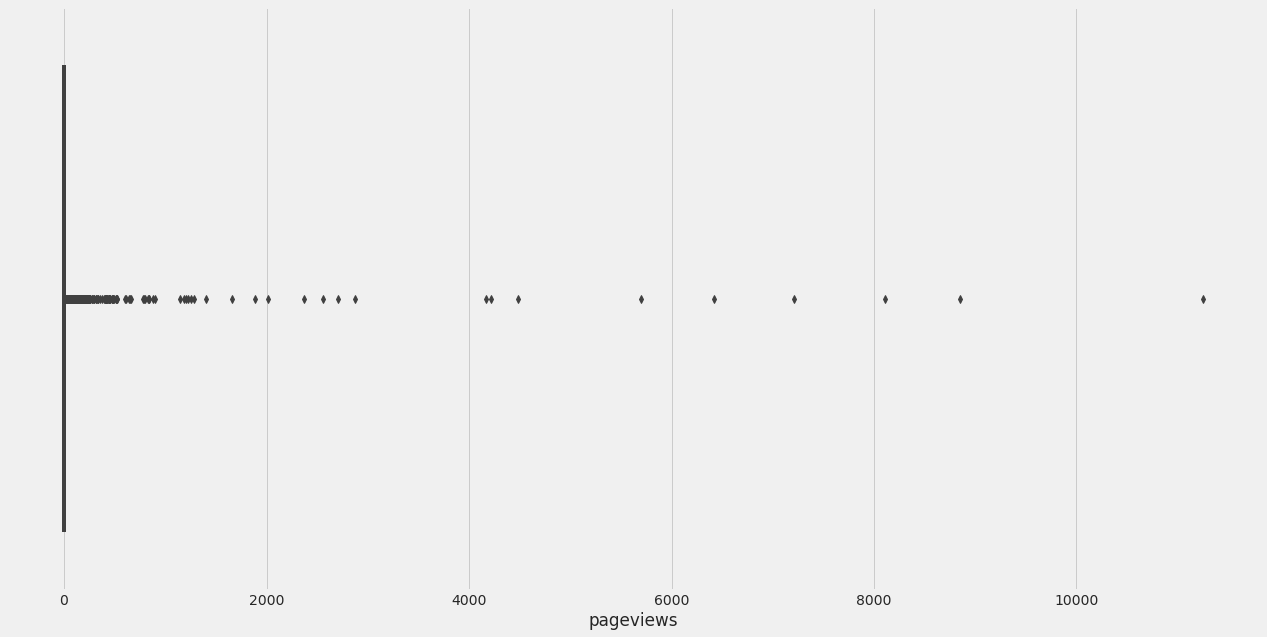

In [14]:
#box plot of total pageviews for each article
sns.boxplot(x=total_pv.pageviews);

In [15]:
for i in np.arange(0.1,1,0.1):
    print(round((i*100),0),"th Percentile of Total Pageviews: ",total_pv.pageviews.quantile(i))

10.0 th Percentile of Total Pageviews:  1.0
20.0 th Percentile of Total Pageviews:  1.0
30.0 th Percentile of Total Pageviews:  1.0
40.0 th Percentile of Total Pageviews:  1.0
50.0 th Percentile of Total Pageviews:  1.0
60.0 th Percentile of Total Pageviews:  2.0
70.0 th Percentile of Total Pageviews:  2.0
80.0 th Percentile of Total Pageviews:  3.0
90.0 th Percentile of Total Pageviews:  5.0


In [16]:
for i in np.arange(0.9,1,0.01):
    print(round((i*100),0),"th Percentile of Total Pageviews: ",total_pv.pageviews.quantile(i))

90.0 th Percentile of Total Pageviews:  5.0
91.0 th Percentile of Total Pageviews:  6.0
92.0 th Percentile of Total Pageviews:  7.0
93.0 th Percentile of Total Pageviews:  8.0
94.0 th Percentile of Total Pageviews:  9.0
95.0 th Percentile of Total Pageviews:  10.0
96.0 th Percentile of Total Pageviews:  13.0
97.0 th Percentile of Total Pageviews:  17.0
98.0 th Percentile of Total Pageviews:  24.0
99.0 th Percentile of Total Pageviews:  47.0


In [17]:
for i in np.arange(0.99,1,0.001):
    print(round((i*100),2),"th Percentile of Total Pageviews: ",total_pv.pageviews.quantile(i))

99.0 th Percentile of Total Pageviews:  47.0
99.1 th Percentile of Total Pageviews:  52.0
99.2 th Percentile of Total Pageviews:  60.64800000000105
99.3 th Percentile of Total Pageviews:  68.0
99.4 th Percentile of Total Pageviews:  79.0
99.5 th Percentile of Total Pageviews:  95.0
99.6 th Percentile of Total Pageviews:  120.82400000000052
99.7 th Percentile of Total Pageviews:  155.73600000000442
99.8 th Percentile of Total Pageviews:  225.91199999999662
99.9 th Percentile of Total Pageviews:  472.12000000011176
100.0 th Percentile of Total Pageviews:  11250.0


In [18]:
for i in np.arange(0.999,1,0.0001):
    print(round((i*100),3),"th Percentile of Total Pageviews: ",total_pv.pageviews.quantile(i))

99.9 th Percentile of Total Pageviews:  472.12000000011176
99.91 th Percentile of Total Pageviews:  498.92879999995057
99.92 th Percentile of Total Pageviews:  586.6543999997812
99.93 th Percentile of Total Pageviews:  679.4579999996131
99.94 th Percentile of Total Pageviews:  834.8679999999804
99.95 th Percentile of Total Pageviews:  1142.4559999988705
99.96 th Percentile of Total Pageviews:  1265.0015999998286
99.97 th Percentile of Total Pageviews:  1985.9896000002045
99.98 th Percentile of Total Pageviews:  3118.1775999920064
99.99 th Percentile of Total Pageviews:  6132.427599995157
100.0 th Percentile of Total Pageviews:  11249.999999982516


In [19]:
#filtering articles with top 0.001th percentile
data_filter =total_pv[total_pv['pageviews'] >= total_pv.pageviews.quantile(0.999)]
natids_filter=data_filter.natid.unique().tolist()
print(len(natids_filter))


45


In [20]:
df_fil=df_fil_day[df_fil_day['natid'].isin (natids_filter)]
print(df_fil.shape)
print('Number of Unique Articles: ', len(df_fil.natid.unique()))

(5389, 11)
Number of Unique Articles:  45


In [21]:
#List of natural Ids of articles
natids=df_fil.natid.unique().tolist()
len(natids)

45

In [22]:
#helper function to create data 
def create_dataframe(natural_ids,df,date,time_from,time_to):
    
    #create dummy dataframe
    res = pd.DataFrame()
    
    for natid in natural_ids:
        #creating a new data frame tm - it has every minute of a day
        tm = (pd.DataFrame(natid,columns=['natid'],
                          index=pd.date_range(f'{date}'+'T00:00:00', f'{date}'+'T23:59:59',freq='1T'))
              .between_time(f'{time_from}',f'{time_to}')
              .reset_index()
        )
        tm.columns=['day_time','natid']
        tm['day_time']=pd.to_datetime(tm['day_time'])
        
        #filter data for each article
        test=df[df['natid']==natid]
        
        #time difference
        time_diff_before=(test['day_time'].tolist()[0])-timedelta(minutes=15)     
        
        time_diff_after=(test['day_time'].tolist()[-1])+timedelta(minutes=5)  
        
        # Merge with the test df
        #first data point always zero, we can change it
     
        test = pd.merge(
            test,
            tm,
            on=['day_time','natid'],
            how='right'
        )
        
        #rolling sum
        #creating cumulative pageviews
        test['pageviews'] =test['pageviews'].fillna(0)
        test['rolling_pv'] =test['pageviews'].rolling(15).sum() # we can change "n"
        test['rolling_pv'] =test['rolling_pv'].fillna(0)
       
        test['return_rolling_pv']=test['rolling_pv'].pct_change(1)
        test['return_rolling_pv']=test['return_rolling_pv'].fillna(0)
        test['return_rolling_pv'] = np.where(test['return_rolling_pv'] == math.inf,
                                             test['rolling_pv'], test['return_rolling_pv'])
        

        #filter data 
        test=test[test['day_time']>time_diff_before]
        
        test=test[test['day_time']<time_diff_after]
        
        res=res.append(test)
        
    return res

In [23]:
#taking data for time between 6am to 10am
data=create_dataframe(natids,df_fil,date,str(frm),str(to))
data.shape

(5445, 13)

### Best Perfroming Articles:

In [24]:
#helper function to calculate sharpe ratio
def sharpe_ratio(df):
    return df['return_rolling_pv'].mean() /df['return_rolling_pv'].std()

In [25]:
#helper function to calculate coefficient of variation
def coefficient_variation(df):
    return df['rolling_pv'].mean() /df['rolling_pv'].std()

In [26]:
#descriptive stats
stat=data.groupby('natid')['rolling_pv'].describe().reset_index()
#skew
skew=data.groupby('natid').agg(skew = pd.NamedAgg(column="rolling_pv", aggfunc="skew"))
#kurtois
kurt=data.groupby('natid').agg( kurt =  pd.NamedAgg(column="rolling_pv", aggfunc=pd.DataFrame.kurt))
#sharpe ratio
sharpe_ratio = data.groupby('natid').apply(sharpe_ratio)
sharpe_ratio=pd.DataFrame({'natid':sharpe_ratio.index, 'sharpe_ratio':sharpe_ratio.values})

#coefficient of variation
cv = data.groupby('natid').apply(coefficient_variation)
cv=pd.DataFrame({'natid':cv.index, 'cv':cv.values})

In [27]:
#merging all data
stat = pd.merge(stat,skew,on=['natid'],how='right')
stat = pd.merge(stat,kurt,on=['natid'],how='right')
stat = pd.merge(stat,sharpe_ratio,on=['natid'],how='right')
stat = pd.merge(stat,cv,on=['natid'],how='right')


In [28]:
stat = stat.sort_values(by=['max','cv','sharpe_ratio'], ascending=False)
stat.head()

,natid,count,mean,std,min,25%,50%,75%,max,skew,kurt,sharpe_ratio,cv
27,blogandpostid/blog/post/51339-638e97f8ffde4c00...,121.0,1253.024793,485.381164,0.0,1222.0,1450.0,1526.0,1697.0,-1.902447,2.478621,0.090940,2.581527
12,blogandpostid/blog/post/4970-63405a74ca7f6d000...,121.0,880.132231,353.918822,0.0,814.0,978.0,1126.0,1278.0,-1.592354,1.834901,0.090878,2.486820
7,blogandpostid/blog/post/2282-638b8e5fedcf34000...,121.0,983.793388,366.441126,0.0,1033.0,1127.0,1161.0,1234.0,-2.217981,3.337827,0.090931,2.684724
4,blogandpostid/blog/post/1360-638bfefcf4926f000...,121.0,803.867769,318.869146,0.0,687.0,945.0,988.0,1095.0,-1.776115,1.991619,0.090881,2.520996
13,blogandpostid/blog/post/4970-6365453c6653f8000...,121.0,700.462810,283.109786,0.0,641.0,786.0,904.0,996.0,-1.561949,1.742621,0.090870,2.474174


## Momentum Indicators

### Combined method: Bollinger Bands + RSI



In [29]:
#sma
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

In [30]:
#Bollinger Bands
def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 1.5
    return upper_bb

In [31]:
def momentum(data,natids):
    #create dummy dataframe
    res = pd.DataFrame()
    
    for natid in natids:
        df=data[data['natid']==natid]
        
        #creating SMA
        df['sma'] = sma(df['rolling_pv'], 7)
        df['sma'] = df['sma'].fillna(0)
        
        #creating upper and lower bands
        df['upper_bb'] = bb(df['rolling_pv'], df['sma'], 15)
        df['upper_bb'] = df['upper_bb'].fillna(0)
        # RSI
        df['rsi'] = df['upper_bb'].transform(lambda x: talib.RSI(x, timeperiod=7))
        df['rsi'] = df['rsi'].fillna(0)
        
        res=res.append(df)
        
    return res

### Top Perfroming

In [33]:
#define number of articles
n=10
top_natids=stat['natid'][0:n].tolist()


print(len(top_natids))

10


In [34]:
top_perf=data[data['natid'].isin (top_natids)]
top_perf.shape

(1210, 13)

In [35]:
#Creating Momentum Indicators
final=momentum(top_perf,top_natids)


In [36]:
#final output
out=final[['natid','title','day_time','pageviews','rolling_pv','rsi']]
out['title'] = out.groupby(['natid'])['title'].bfill()
out['title'] = out.groupby(['natid'])['title'].ffill()
out.head()

,natid,title,day_time,pageviews,rolling_pv,rsi
0,blogandpostid/blog/post/51339-638e97f8ffde4c00...,Elon Musk Has Outfitted Twitter’s Headquarters...,2022-12-06 07:00:00,61.0,0.0,0.0
1,blogandpostid/blog/post/51339-638e97f8ffde4c00...,Elon Musk Has Outfitted Twitter’s Headquarters...,2022-12-06 07:01:00,61.0,0.0,0.0
2,blogandpostid/blog/post/51339-638e97f8ffde4c00...,Elon Musk Has Outfitted Twitter’s Headquarters...,2022-12-06 07:02:00,73.0,0.0,0.0
3,blogandpostid/blog/post/51339-638e97f8ffde4c00...,Elon Musk Has Outfitted Twitter’s Headquarters...,2022-12-06 07:03:00,78.0,0.0,0.0
4,blogandpostid/blog/post/51339-638e97f8ffde4c00...,Elon Musk Has Outfitted Twitter’s Headquarters...,2022-12-06 07:04:00,69.0,0.0,0.0


In [37]:
out.title.unique().tolist()

['Elon Musk Has Outfitted Twitter’s Headquarters With Bedrooms For Employees',
 'London’s Culture Crush: What To See, Do And Experience In December',
 'Trump Owed Hidden Debt While In Office',
 'Today’s Wordle #535 Hints, Clues And Answer For Tuesday, December 6th',
 'Tamara Mellon On Her Celestial-Inspired A/W22 Collection',
 '2022 Major Layoffs Grow: PepsiCo Laying Off Hundreds Of Staff, Report Says',
 'Ukraine Pulled Ex-Soviet Recon Drones Out Of Storage, Added Bombs And Sent Them Hurtling Toward Russia',
 'Ex-Twitter Employees Begin Lawyering Up To Face Elon Musk',
 'Here’s Exactly When ‘Overwatch 2’ Season 2 Goes Live',
 'Bouncing Back From A Toxic Work Relationship']

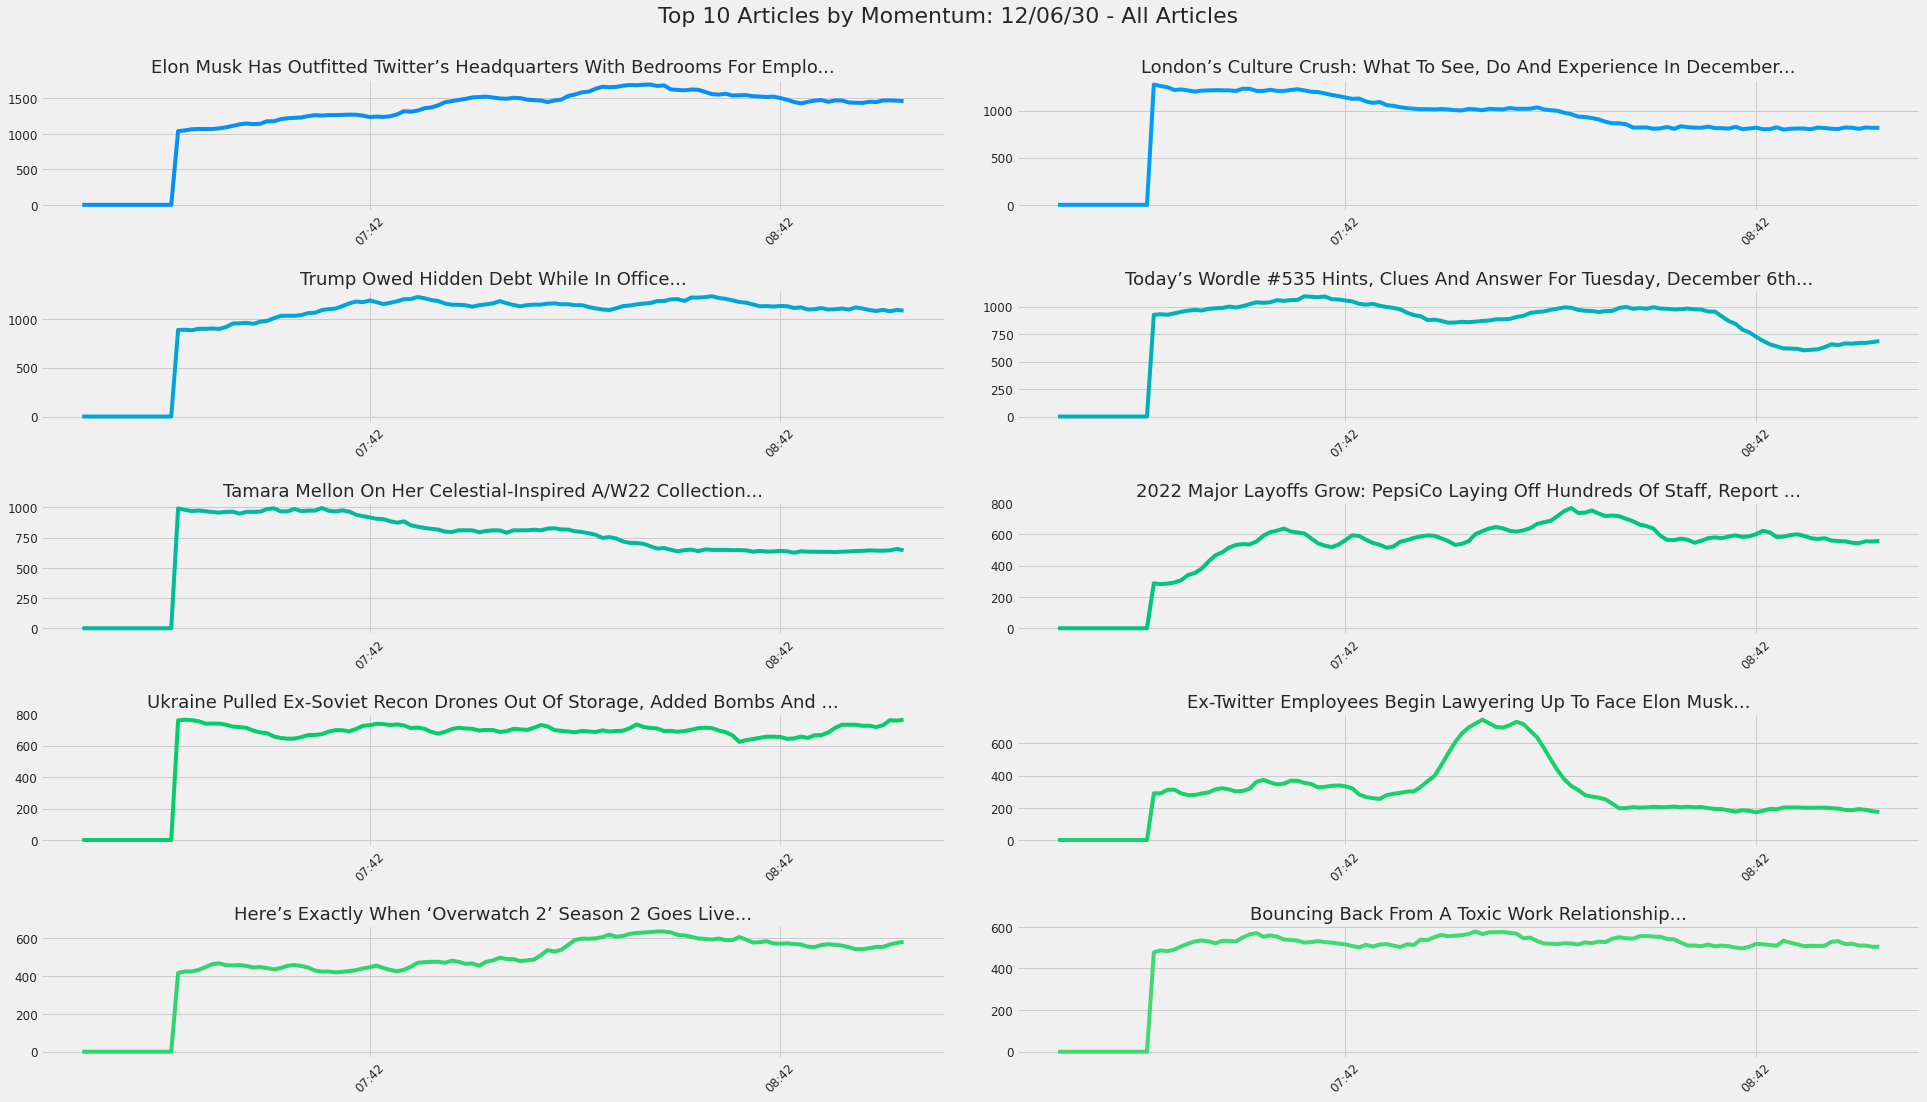

In [38]:
ten_charts(
    df=out,
    fn='top_7am-9am_06Dec_all_articles',
    title='Top 10 Articles by Momentum: 12/06/30 - All Articles'
)

### Bottom




In [39]:
stat.tail(10)

,natid,count,mean,std,min,25%,50%,75%,max,skew,kurt,sharpe_ratio,cv
25,blogandpostid/blog/post/51239-638e6d777e611a00...,121.0,67.404959,29.532631,0.0,54.0,74.0,90.0,114.0,-1.105031,0.646020,0.090889,2.282389
9,blogandpostid/blog/post/2907-6388a124416eea000...,121.0,71.710744,27.411201,0.0,72.0,78.0,86.0,103.0,-1.972639,2.799956,0.091189,2.616111
40,blogandpostid/blog/post/7235-638a41d823c5eb000...,121.0,56.743802,28.691325,0.0,41.0,67.0,74.0,102.0,-0.703060,-0.435491,0.097155,1.977734
5,blogandpostid/blog/post/1360-638bff03f4926f000...,121.0,71.818182,28.024097,0.0,67.0,83.0,89.0,99.0,-1.855293,2.323585,0.091509,2.562730
21,blogandpostid/blog/post/50531-638f105dacf24d00...,121.0,52.438017,25.294233,0.0,42.0,52.0,69.0,96.0,-0.486753,0.094035,0.091104,2.073121
39,blogandpostid/blog/post/6614-638e11d26f60d0000...,121.0,52.033058,22.356928,0.0,44.0,58.0,66.0,92.0,-1.184420,0.956244,0.092951,2.327380
3,blogandpostid/blog/post/1334-6329fa70f8b1f9000...,121.0,58.545455,24.203306,0.0,52.0,64.0,75.0,89.0,-1.445473,1.363935,0.091762,2.418903
14,blogandpostid/blog/post/50012-633b5a4ce39b5800...,121.0,58.859504,22.963488,0.0,59.0,66.0,71.0,85.0,-1.844944,2.369609,0.092411,2.563178
0,blogandpostid/blog/post/1174-638c9bdaedcf34000...,121.0,51.776860,19.829056,0.0,53.0,56.0,61.0,76.0,-1.940982,2.794542,0.091766,2.611161
8,blogandpostid/blog/post/2799-6335b3e2e39b58000...,121.0,51.710744,19.599506,0.0,52.0,58.0,62.0,71.0,-2.065640,2.948082,0.090806,2.638370


In [40]:
bottom_natids=stat['natid'][-n:].tolist()
print(len(bottom_natids))
worst_perf=data[data['natid'].isin (bottom_natids)]
worst_perf.shape

10


(1210, 13)

In [41]:
#Creating Momentum Indicators
bottom=momentum(worst_perf,bottom_natids)
bottom.head()

,natid,title,pub_date,pub_time,pub_date_time,pageviews,hour,minute,ga_date,time,day_time,rolling_pv,return_rolling_pv,sma,upper_bb,rsi
0,blogandpostid/blog/post/51239-638e6d777e611a00...,L.A. Man Faces 21 Years In Prison After Pleadi...,2022-12-05,17:18:00,2022-12-05 17:18:00,3.0,7.0,0.0,2022-12-06,07:00:00,2022-12-06 07:00:00,0.0,0.0,0.0,0.0,0.0
1,blogandpostid/blog/post/51239-638e6d777e611a00...,L.A. Man Faces 21 Years In Prison After Pleadi...,2022-12-05,17:18:00,2022-12-05 17:18:00,6.0,7.0,1.0,2022-12-06,07:01:00,2022-12-06 07:01:00,0.0,0.0,0.0,0.0,0.0
2,blogandpostid/blog/post/51239-638e6d777e611a00...,L.A. Man Faces 21 Years In Prison After Pleadi...,2022-12-05,17:18:00,2022-12-05 17:18:00,3.0,7.0,2.0,2022-12-06,07:02:00,2022-12-06 07:02:00,0.0,0.0,0.0,0.0,0.0
3,blogandpostid/blog/post/51239-638e6d777e611a00...,L.A. Man Faces 21 Years In Prison After Pleadi...,2022-12-05,17:18:00,2022-12-05 17:18:00,5.0,7.0,3.0,2022-12-06,07:03:00,2022-12-06 07:03:00,0.0,0.0,0.0,0.0,0.0
4,blogandpostid/blog/post/51239-638e6d777e611a00...,L.A. Man Faces 21 Years In Prison After Pleadi...,2022-12-05,17:18:00,2022-12-05 17:18:00,5.0,7.0,4.0,2022-12-06,07:04:00,2022-12-06 07:04:00,0.0,0.0,0.0,0.0,0.0


In [42]:
#final output
out_bottom=bottom[['natid','title','day_time','pageviews','rolling_pv','rsi']]
out_bottom['title'] = out_bottom.groupby(['natid'])['title'].bfill()
out_bottom['title'] = out_bottom.groupby(['natid'])['title'].ffill()
out_bottom.head()

,natid,title,day_time,pageviews,rolling_pv,rsi
0,blogandpostid/blog/post/51239-638e6d777e611a00...,L.A. Man Faces 21 Years In Prison After Pleadi...,2022-12-06 07:00:00,3.0,0.0,0.0
1,blogandpostid/blog/post/51239-638e6d777e611a00...,L.A. Man Faces 21 Years In Prison After Pleadi...,2022-12-06 07:01:00,6.0,0.0,0.0
2,blogandpostid/blog/post/51239-638e6d777e611a00...,L.A. Man Faces 21 Years In Prison After Pleadi...,2022-12-06 07:02:00,3.0,0.0,0.0
3,blogandpostid/blog/post/51239-638e6d777e611a00...,L.A. Man Faces 21 Years In Prison After Pleadi...,2022-12-06 07:03:00,5.0,0.0,0.0
4,blogandpostid/blog/post/51239-638e6d777e611a00...,L.A. Man Faces 21 Years In Prison After Pleadi...,2022-12-06 07:04:00,5.0,0.0,0.0


In [43]:
out_bottom.title.unique().tolist()

['L.A. Man Faces 21 Years In Prison After Pleading Guilty To Shooting Lady Gaga’s Dog Walker',
 'Apple iOS 16.1.2 Release: Should You Upgrade?',
 'Runway Raises $50 Million At $500 Million Valuation As Generative AI Craze Continues',
 'Today’s Wordle #533 Hints, Clues And Answer For Sunday, December 4th',
 'Musk’s Neuralink Under Federal Investigation Over Alleged Animal Welfare Abuses, Report Says',
 '5 Student Loan Forgiveness Updates Borrowers Should Know About',
 'Meet The Four Billionaires Behind H-E-B Supermarkets, Texas’ Largest Private Employer',
 'The World’s Highest-Paid Soccer Players 2022: Kylian Mbappé Claims No. 1 As Erling Haaland Debuts',
 'Here Are All The ‘Fortnite’ Chapter 4 Battle Pass Skins And Cosmetics',
 'Meet The Most Successful Female Entrepreneur In American History']

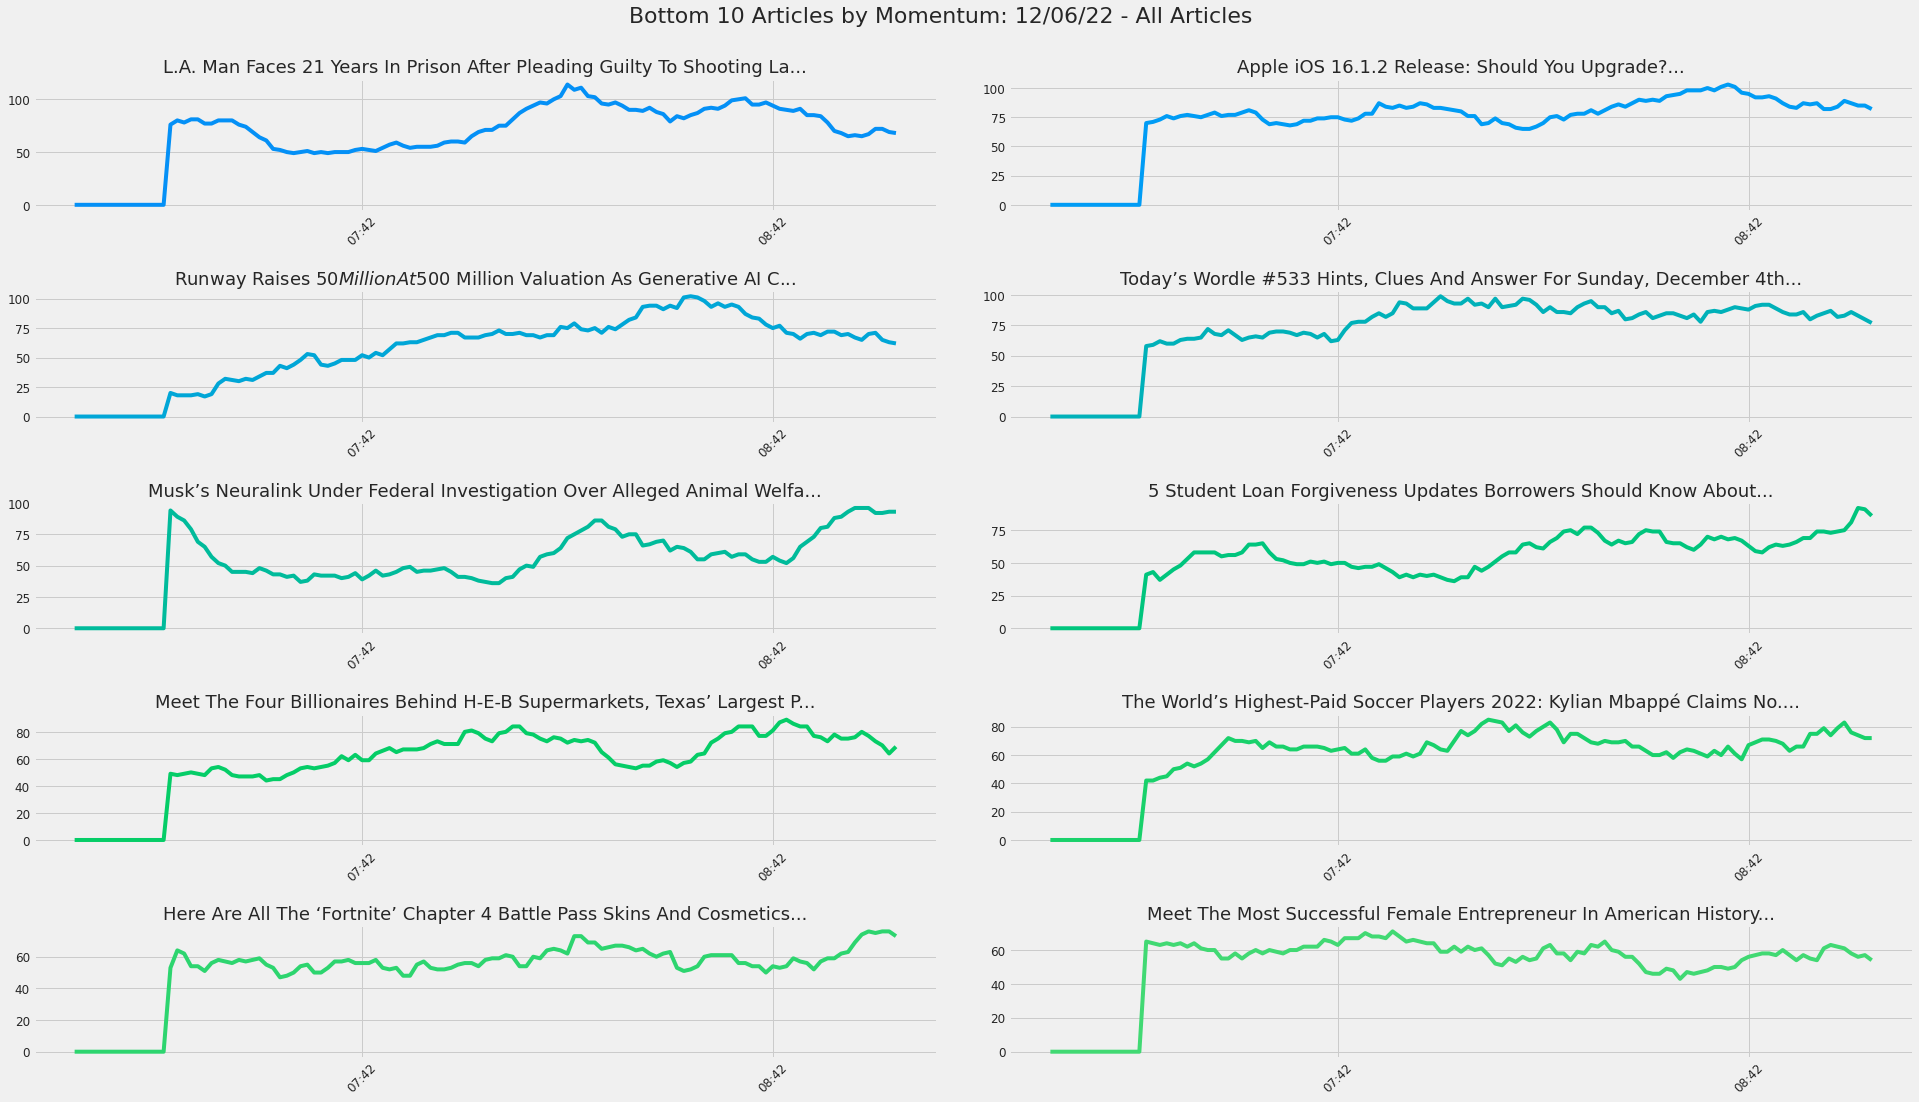

In [44]:
ten_charts(
    df=out_bottom,
    fn='Bottom_7am-9am_06Dec_all_articles',
    title='Bottom 10 Articles by Momentum: 12/06/22 - All Articles'
)